# import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### load data

Shape: (1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLev

<Axes: >

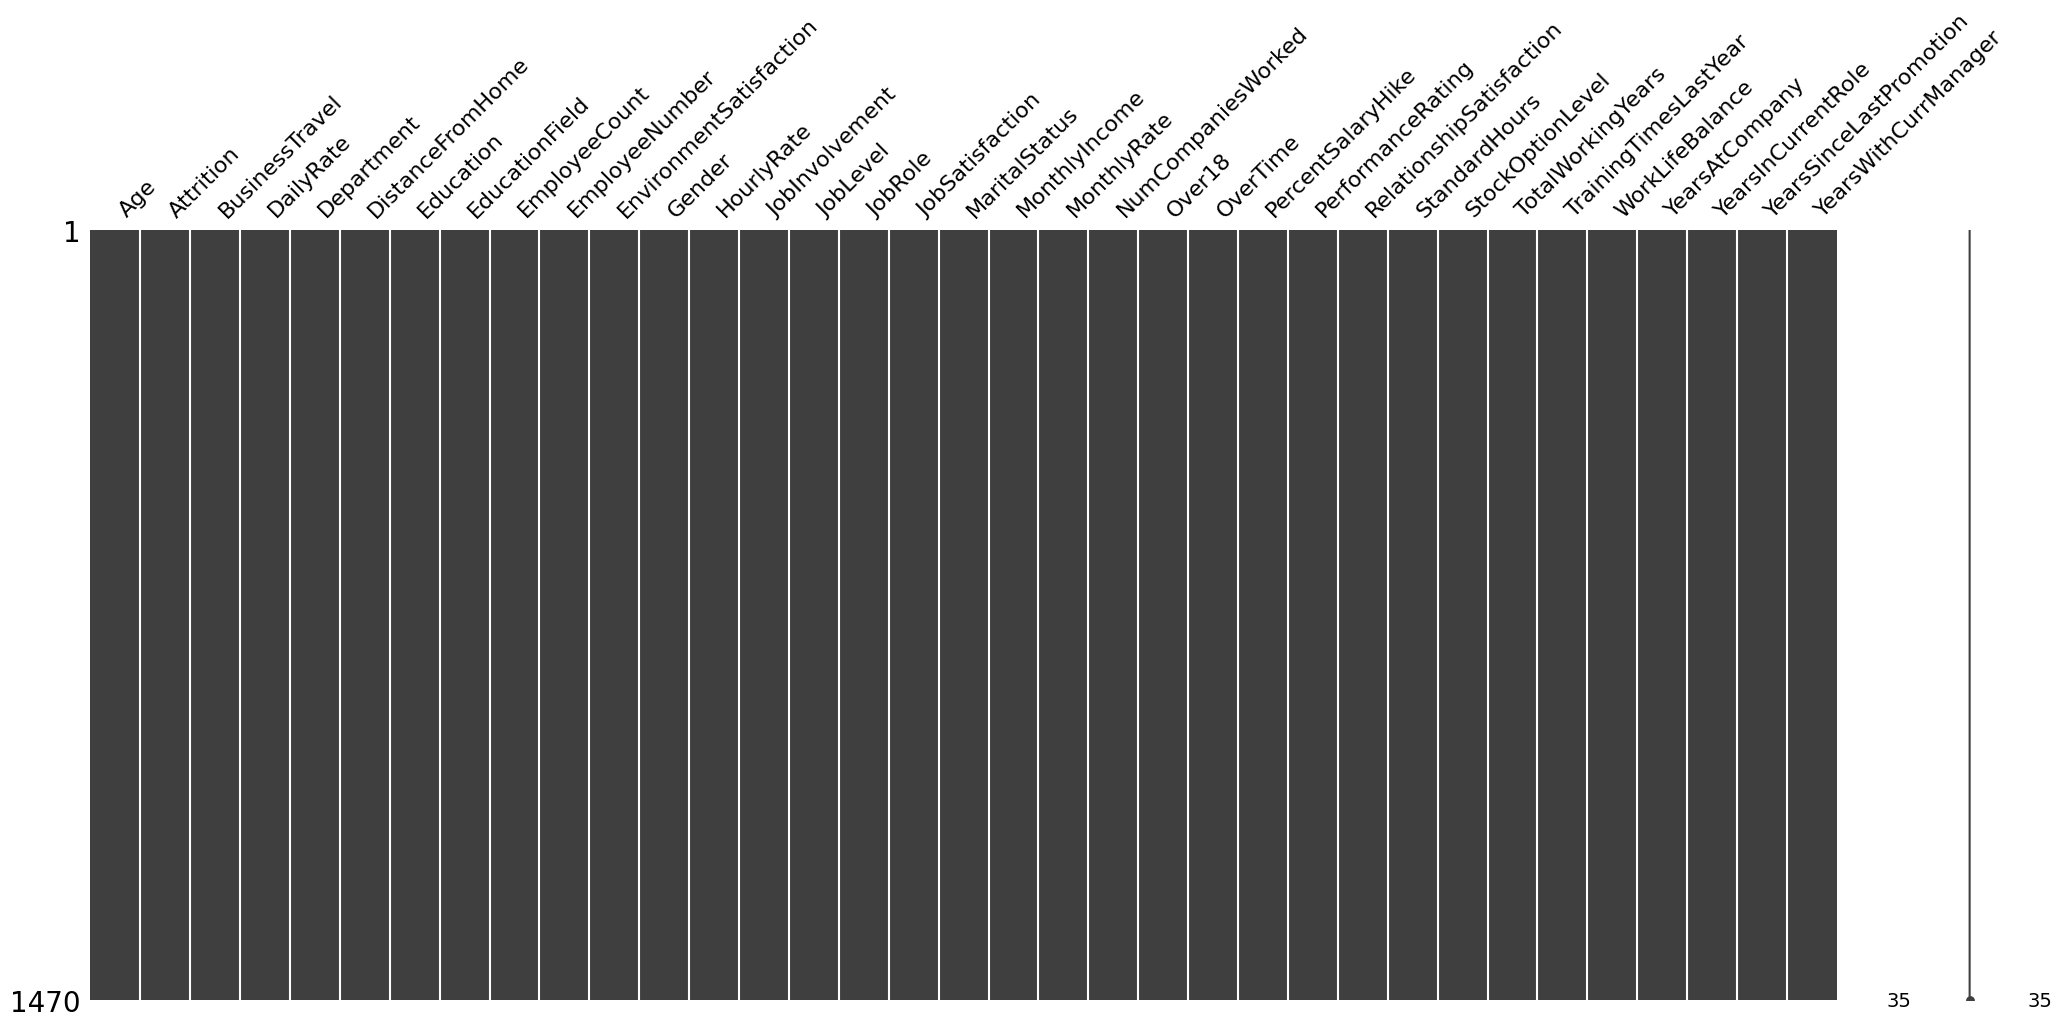

In [2]:
df = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')

print(f"Shape: {df.shape}")

df.head()

df.info()

df.describe()

cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include='number').columns.tolist()
print(f"Categóricas: {len(cat_cols)} → {cat_cols}")
print(f"Numéricas: {len(num_cols)} → {num_cols}")

msno.matrix(df)

df.shape confirma que o dataset tem 1470 linhas e 35 colunas.

df.info() mostra que não há valores nulos em nenhuma coluna (todas com 1470 non-null), o que é excelente.

A visualização com msno.matrix(df) confirma visualmente que não há dados ausentes (todas as barras estão preenchidas até o topo).

# outliers

In [3]:

def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    return outliers
        
outliers_age = detect_outliers(df, 'Age')
print(outliers_age)

for col in num_cols:
    outliers = detect_outliers(df, col)
    if len(outliers) > 0:
        print(f"Outliers encontrados em: {col} → {len(outliers)} outliers")

Empty DataFrame
Columns: [Age, Attrition, BusinessTravel, DailyRate, Department, DistanceFromHome, Education, EducationField, EmployeeCount, EmployeeNumber, EnvironmentSatisfaction, Gender, HourlyRate, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, MonthlyRate, NumCompaniesWorked, Over18, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StandardHours, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager]
Index: []

[0 rows x 35 columns]
Outliers encontrados em: MonthlyIncome → 114 outliers
Outliers encontrados em: NumCompaniesWorked → 52 outliers
Outliers encontrados em: PerformanceRating → 226 outliers
Outliers encontrados em: StockOptionLevel → 85 outliers
Outliers encontrados em: TotalWorkingYears → 63 outliers
Outliers encontrados em: TrainingTimesLastYear → 238 outliers
Outliers encontrados em: YearsAtCompany → 104 ou

Achei muitos outliers em variáveis críticas, vou combinar log transform com capping por percentis — evita distorção, mantém padrões e melhora o modelo.

### Log transform

In [4]:
df['MonthlyIncome_log'] = np.log1p(df['MonthlyIncome'])
df['TotalWorkingYears_log'] = np.log1p(df['TotalWorkingYears'])

Isso transforma as variáveis MonthlyIncome e TotalWorkingYears para reduzir a assimetria positiva (skewness) e o impacto de outliers.

- Evitar erro com log(0)

- Suavizar valores muito altos

- Manter estabilidade numérica

### Capping 

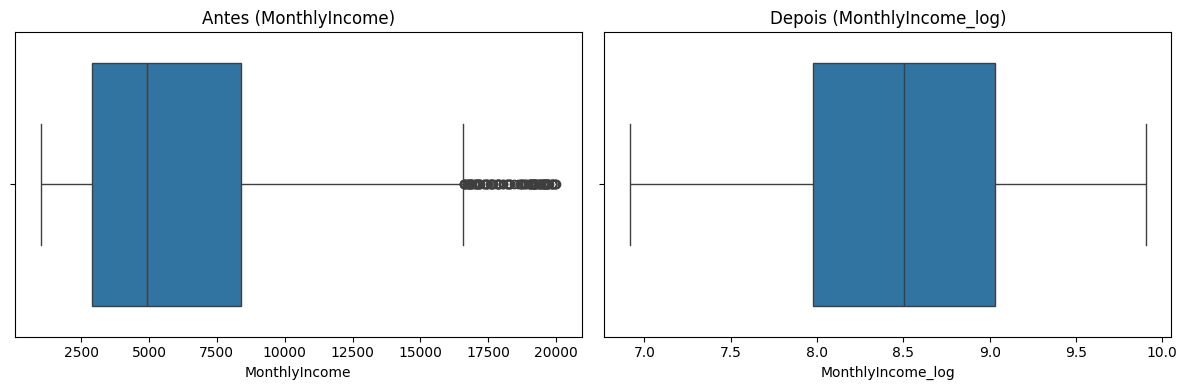

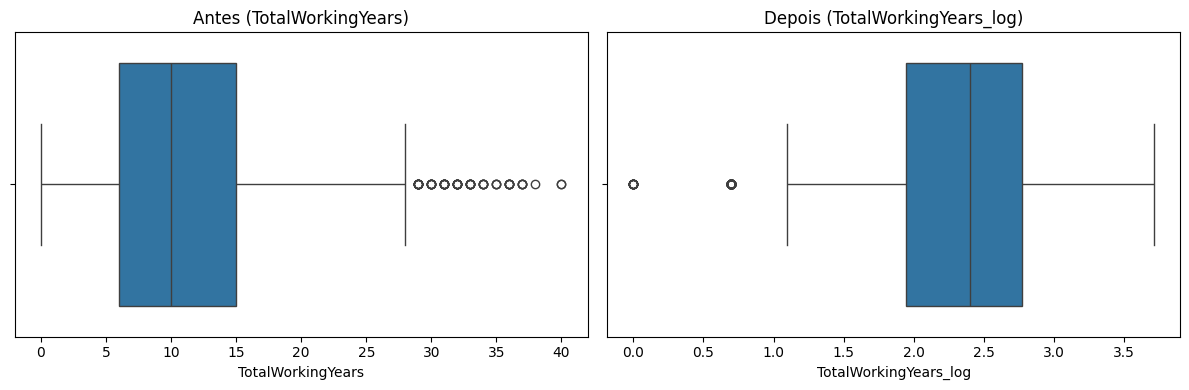

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyIncome_log,TotalWorkingYears_log
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,0.793878,11.279592,2.799320,2.761224,6.980272,4.214966,2.178912,4.102721,8.552752,2.294246
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,0.852077,7.780782,1.289271,0.706476,6.004901,3.576459,3.188426,3.503717,0.664313,0.698631
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,6.917706,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,7.976595,1.945910
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,8.501061,2.397895
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,9.033603,2.772589
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,3.000000,40.000000,6.000000,4.000000,31.000000,15.000000,14.000000,14.000000,9.903488,3.713572


In [5]:
def cap_outliers(series, lower=0.01, upper=0.99):
    q_low = series.quantile(lower)
    q_high = series.quantile(upper)
    return series.clip(q_low, q_high)

cols_to_cap = [
    'NumCompaniesWorked',
    'PerformanceRating',
    'StockOptionLevel',
    'TrainingTimesLastYear',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

for col in cols_to_cap:
    df[col] = cap_outliers(df[col])

df_original = df.copy()
cols = ['MonthlyIncome', 'TotalWorkingYears']
for col in cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_original[col])
    plt.title(f'Antes ({col})')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[f'{col}_log'])
    plt.title(f'Depois ({col}_log)')

    plt.tight_layout()
    plt.show()


df.describe()

TotalWorkingYears:
- Antes: Há vários outliers após os 25 anos de trabalho, o que é comum em dados de experiência profissional.

- Depois (log): A transformação reduziu a dispersão, mas ainda permanece um outlier ou outro visível, indicando que:

    - A transformação log ajudou, mas não normalizou completamente.

    - Pode haver valores naturalmente discrepantes (ex: alguém com 40 anos de experiência).



# Limpar Dataset

In [6]:
df = df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])

df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

df = pd.get_dummies(df, columns=['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime'], drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   int64  
 1   Attrition                          1470 non-null   int64  
 2   DailyRate                          1470 non-null   int64  
 3   DistanceFromHome                   1470 non-null   int64  
 4   Education                          1470 non-null   int64  
 5   EmployeeNumber                     1470 non-null   int64  
 6   EnvironmentSatisfaction            1470 non-null   int64  
 7   Gender                             1470 non-null   int64  
 8   HourlyRate                         1470 non-null   int64  
 9   JobInvolvement                     1470 non-null   int64  
 10  JobLevel                           1470 non-null   int64  
 11  JobSatisfaction                    1470 non-null   int64

# Análise Univariada

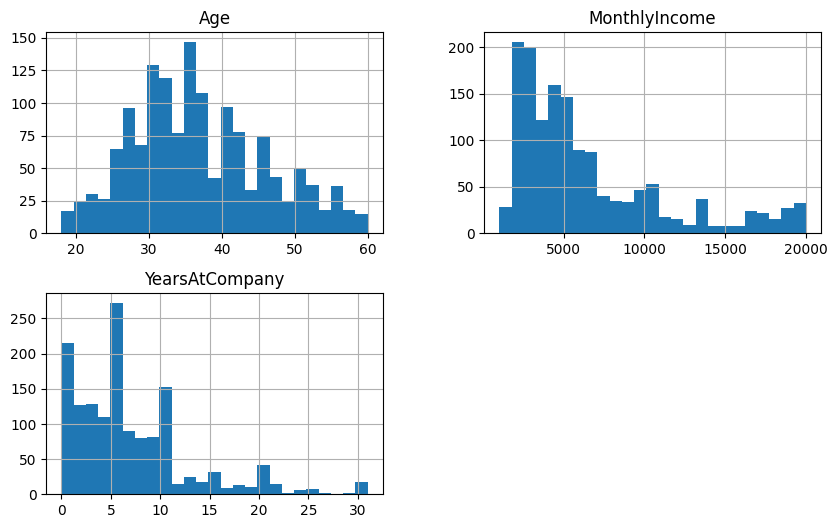

In [7]:
df[['Age', 'MonthlyIncome', 'YearsAtCompany']].hist(bins=25, figsize=(10, 6))
plt.show()

Age: Pode influenciar a rotatividade, pois funcionários mais jovens ou mais velhos podem ter diferentes comportamentos de permanência.

MonthlyIncome: Alta correlação com satisfação e estabilidade no emprego. Funcionários com maior salário tendem a ficar mais tempo.

YearsAtCompany: Indica a experiência na empresa, com mais anos podendo indicar maior lealdade ou maior chance de rotatividade por insatisfação.

# Análise Bivariada

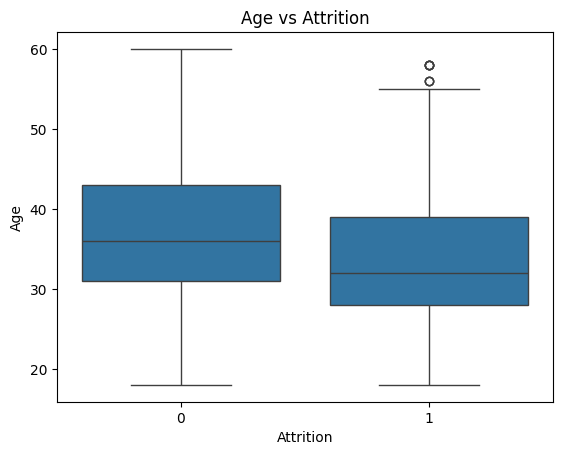

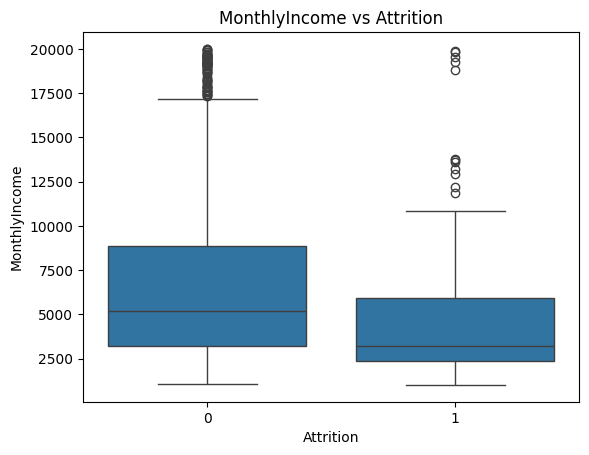

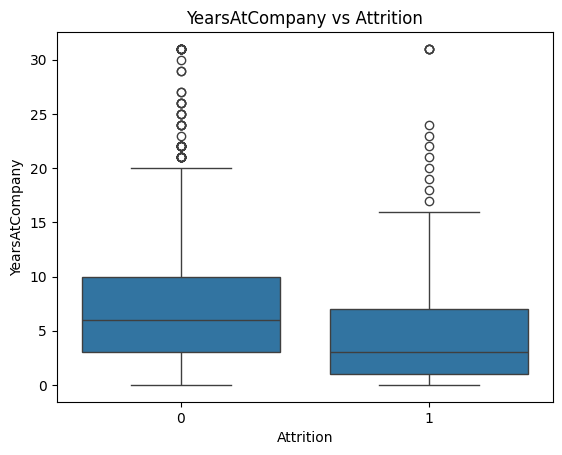

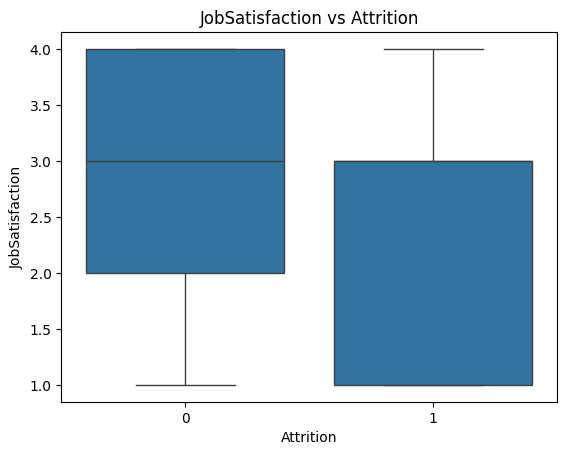

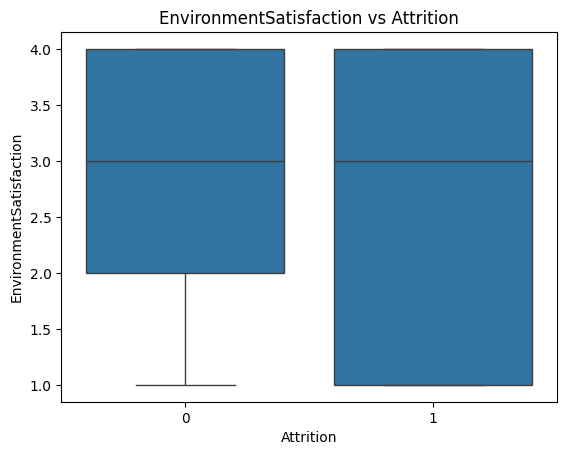

In [8]:
selected_cols = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'JobSatisfaction', 'EnvironmentSatisfaction']

for col in selected_cols:
    sns.boxplot(x='Attrition', y=col, data=df)
    plt.title(f'{col} vs Attrition')
    plt.show()

Funcionários que saem tendem a ser mais jovens e com menos tempo de empresa.

O salário parece ser menor em quem sai.

A satisfação com o ambiente parece bem distribuída, sem diferença gritante, o que pode indicar menor relevância.

In [9]:
df.to_csv('../data/processed/employee_attrition_processed.csv', index=False)

# ✅ Insight Final

Funcionários que pedem desligamento geralmente:

São mais jovens.

Têm menos tempo de casa (YearsAtCompany).

Recebem salários mensais menores.

Trabalham mais horas extras (OverTime).

Estão concentrados em certos cargos e estados civis (ex: solteiros).

🔍 Recomendações para RH:

Monitorar colaboradores com esse perfil.

Investir em retenção para jovens talentos e cargos mais impactados.

Avaliar política de horas extras e remuneração.